In [1]:
import os
import cv2
from skimage.feature import hog, graycomatrix, graycoprops
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
import math
import re
from collections import defaultdict
from sklearn.preprocessing import StandardScaler

In [2]:
# Set the path to the folder containing your dataset
# Adjust this path to where you saved the images
dataset_folder = 'Cell_Images'

# We will store the loaded images in a list
cell_loaded_images = []
# It's also useful to store their filenames
cell_image_filenames = []

print(f"Starting to load images from: {dataset_folder}")

# Loop through every file in the folder
for filename in os.listdir(dataset_folder):
    
    # Check if the file is an image (e.g., .jpg, .png)
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        
        # Create the full path to the image
        image_path = os.path.join(dataset_folder, filename)
        
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        
        if image is not None:
            # If loading was successful, add it to our list
            cell_loaded_images.append(image)
            cell_image_filenames.append(filename)
        else:
            print(f"Warning: Could not load {filename}")

print(f"---")
print(f"Success! Loaded {len(cell_loaded_images)} images.")
print(f"Example: The first image '{cell_image_filenames[0]}' has dimensions: {cell_loaded_images[0].shape}")

# ...existing code...
df = pd.read_csv("final_labels_manual.csv")

def normalize_id(s):
    return os.path.splitext(os.path.basename(str(s)).strip())[0].lower()

# build label map keyed by basename without extension (normalized)
label_map = { normalize_id(cid): lab for cid, lab in zip(df["cell_id"], df["label"]) }

y_labels = []
missing = []
for fname in cell_image_filenames:
    key = normalize_id(fname)
    if key in label_map:
        y_labels.append(int(label_map[key]))
    else:
        missing.append(fname)

if missing:
    raise KeyError(f"{len(missing)} filenames not found in label_map. Examples: {missing[:10]}")
# ...existing code...

Starting to load images from: Cell_Images
---
Success! Loaded 27584 images.
Example: The first image 'IMG_4171_63.jpg' has dimensions: (75, 100, 3)


In [3]:
from skimage.feature import local_binary_pattern

# --- NEW: Function to build and apply Gabor filters ---
def build_gabor_filters():
    """Builds a bank of Gabor filters."""
    filters = []
    ksize = 9  # Kernel size
    # Theta (orientation) - we'll use 8 orientations
    for theta in np.arange(0, np.pi, np.pi / 8):
        # Lambda (wavelength) - we'll use 4 different scales
        for lambd in [1.0, 3.0, 5.0, 7.0]:
            # Other Gabor parameters (gamma=0.5, psi=0 are common)
            kern = cv2.getGaborKernel((ksize, ksize), 
                                      sigma=4.0, 
                                      theta=theta, 
                                      lambd=lambd, 
                                      gamma=0.5, 
                                      psi=0, 
                                      ktype=cv2.CV_32F)
            kern /= 1.5 * kern.sum()
            filters.append(kern)
    return filters

def apply_gabor_filters(gray_img, gabor_filters):
    """Applies Gabor filter bank and returns features (mean, std of responses)."""
    features = []
    for kern in gabor_filters:
        fimg = cv2.filter2D(gray_img, cv2.CV_8UC3, kern)
        # Get the mean and std dev of the filter response
        features.append(np.mean(fimg))
        features.append(np.std(fimg))
    return features

# --- Pre-build the filter bank once to save time ---
GABOR_FILTERS = build_gabor_filters()


def extract_all_features(cell):
    """
    Extracts an enhanced combined feature vector from a single 100x75 image cell.
    
    Features:
    1. HSV Stats (6 features)
    2. GLCM Properties (4 features)
    3. HOG Features (192 features)
    4. Edge Density (1 feature)
    5. Harris Corner Count (1 feature)
    6. FAST Keypoint Count (1 feature)
    7. L*a*b* Stats (6 features)
    8. Hu Moments (7 features)
    9. LBP Histogram (26 features)
    10. NEW: Gabor Filter Features (8 orientations * 4 freq * 2 stats = 64 features)
    
    Total Features: 244 (original) + 64 = 308 features
    """
    
    # --- 0. Prerequisites ---
    gray_cell = cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)
    gray_cell_uint8 = cv2.convertScaleAbs(gray_cell)
    
    feature_vector = []
    # NEW: Define the total expected feature count for error handling
    total_feature_count = 308 

    try:
        # --- 1. HSV Stats (6 features) ---
        hsv_cell = cv2.cvtColor(cell, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv_cell)
        feature_vector.extend([np.mean(h), np.std(h), np.mean(s), np.std(s), np.mean(v), np.std(v)])
        
        # --- 2. GLCM Properties (4 features) ---
        glcm = graycomatrix(gray_cell_uint8, [1], [0], 256, symmetric=True, normed=True)
        feature_vector.extend([
            graycoprops(glcm, 'contrast')[0, 0],
            graycoprops(glcm, 'homogeneity')[0, 0],
            graycoprops(glcm, 'energy')[0, 0],
            graycoprops(glcm, 'correlation')[0, 0]
        ])

        # --- 3. HOG Features (192 features) ---
        hog_features = hog(gray_cell, orientations=8, pixels_per_cell=(16, 16),
                           cells_per_block=(1, 1), visualize=False, block_norm='L2-Hys')
        feature_vector.extend(hog_features)

        # --- 4. Edge Density (1 feature) ---
        edges = cv2.Canny(cell, 100, 200)
        feature_vector.append(np.mean(edges) / 255.0)

        # --- 5. Harris Corner Count (1 feature) ---
        dst = cv2.cornerHarris(gray_cell, 2, 3, 0.04)
        feature_vector.append(np.sum(dst > 0.01 * dst.max()))

        # --- 6. FAST Keypoint Count (1 feature) ---
        fast = cv2.FastFeatureDetector_create()
        keypoints = fast.detect(gray_cell, None)
        feature_vector.append(len(keypoints))

        # --- 7. L*a*b* Color Stats (6 features) ---
        lab_cell = cv2.cvtColor(cell, cv2.COLOR_BGR2Lab)
        l, a, b = cv2.split(lab_cell)
        feature_vector.extend([np.mean(l), np.std(l), np.mean(a), np.std(a), np.mean(b), np.std(b)])

        # --- 8. Hu Moments (7 features) ---
        moments = cv2.moments(gray_cell_uint8)
        hu_moments = cv2.HuMoments(moments)
        hu_moments_log = -1 * np.copysign(1.0, hu_moments) * np.log10(np.abs(hu_moments) + 1e-7)
        feature_vector.extend(hu_moments_log.flatten())

        # --- 9. LBP Histogram (26 features) ---
        n_points = 24
        radius = 3
        lbp = local_binary_pattern(gray_cell_uint8, n_points, radius, method='uniform')
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        feature_vector.extend(hist)
        
        # --- 10. NEW: Gabor Filter Features (64 features) ---
        # We apply the pre-built filter bank to the cell
        gabor_features = apply_gabor_filters(gray_cell_uint8, GABOR_FILTERS)
        feature_vector.extend(gabor_features)

    except Exception as e:
        print(f"Error extracting features from a cell: {e}")
        # Return a vector of zeros matching the new total size
        return np.zeros(total_feature_count)

    # Return the final, flat vector
    return np.array(feature_vector)

In [8]:
# # filenames now like: "<image_id>_<cellno>" e.g. "1244_55.jpg" or "1244_55"
# pat = re.compile(r"(?P<imgid>.+?)_(?P<cell>\d+)(?:\..+)?$")

# groups = defaultdict(list)
# for img_arr, fname in zip(cell_loaded_images, cell_image_filenames):
#     m = pat.match(fname)
#     if not m:
#         # try basename fallback
#         m = pat.match(os.path.basename(fname))
#     if not m:
#         # skip files that don't follow the new naming convention
#         continue
#     imgid = m.group("imgid")
#     cell_no = int(m.group("cell"))  # numeric cell index
#     # label lookup using filename (try exact, then basename)
#     label = label_map.get(fname, label_map.get(os.path.basename(fname), np.nan))
#     groups[imgid].append((cell_no, img_arr, label, fname))

# # Build rows: only keep original images that have exactly 64 cells, sorted by cell number
# cell_images_rows = []
# label_rows = []
# for imgid, items in groups.items():
#     if len(items) != 64:
#         # skip incomplete images (or change this logic to pad/handle differently)
#         continue
#     # sort by numeric cell index (assumes cell indices 0..63 or 1..64)
#     items_sorted = sorted(items, key=lambda x: x[0])
#     imgs = [np.asarray(it[1], dtype=np.uint8) for it in items_sorted]
#     labs = [int(it[2]) if not pd.isna(it[2]) else 0 for it in items_sorted]
#     cell_images_rows.append(imgs)
#     label_rows.append(labs)

# # Final 2D arrays: each row corresponds to one original image (64 cells)
# cell_images_2d = np.array(cell_images_rows, dtype=object)  # shape (num_images, 64)
# y_labels_2d = np.array(label_rows, dtype=int)              # shape (num_images, 64)

# print("cell_images_2d.shape:", cell_images_2d.shape)
# print("y_labels_2d.shape:", y_labels_2d.shape)
# # ...existing code...

In [9]:
# def rebuild_and_mark(cells, labels, grid_size=8, green_value=200, tint_alpha=0.6):
#     """
#     Apply a full green overlay to cells with label==1.
#     tint_alpha: 0.0 = no tint, 1.0 = full green
#     green_value: 0-255 intensity for green channel (BGR)
#     """
#     cells_list = [np.asarray(c, dtype=np.uint8) for c in list(cells)]
#     num_cells = len(cells_list)
#     assert num_cells == grid_size * grid_size, "Expected 64 cells"

#     h, w = cells_list[0].shape[:2]
#     channels = 3
#     H, W = h * grid_size, w * grid_size
#     final_image = np.zeros((H, W, channels), dtype=np.uint8)

#     # green tint image (BGR)
#     tint_img = np.zeros((h, w, 3), dtype=np.uint8)
#     tint_img[:] = (0, green_value, 0)

#     idx = 0
#     for row in range(grid_size):
#         for col in range(grid_size):
#             cell = cells_list[idx].copy()
#             # ensure 3-channel uint8
#             if cell.ndim == 2:
#                 cell = cv2.cvtColor(cell, cv2.COLOR_GRAY2BGR)
#             elif cell.shape[2] == 1:
#                 cell = cv2.cvtColor(cell, cv2.COLOR_GRAY2BGR)
#             cell = cell.astype(np.uint8)

#             if labels[idx] == 1:
#                 # full-cell green overlay
#                 cell = cv2.addWeighted(cell, 1.0 - tint_alpha, tint_img, tint_alpha, 0)

#             final_image[row*h:(row+1)*h, col*w:(col+1)*w] = cell
#             idx += 1

#     return final_image

In [10]:
# # ...existing code...
# # fix LABEL_OUTPUT_FOLDER stray quote
# LABEL_OUTPUT_FOLDER = 'Labeled_images'
# label_dir = os.path.join(LABEL_OUTPUT_FOLDER)
# os.makedirs(label_dir, exist_ok=True)
# for cells, labels in zip(cell_images_2d, y_labels_2d):
#     image = rebuild_and_mark(cells, labels)
#     cv2.imwrite(os.path.join(label_dir, f"labeled_image_{np.random.randint(1e6)}.png"), image)
# # ...existing code...

In [19]:

print("Starting feature extraction for all cells...")

# X_data will be your feature matrix (e.g., 12800 rows x 205 columns)
X_data = []
for image, filename in zip(cell_loaded_images,cell_image_filenames):
        
        # Extract the 205 features from the 100x75 cell
        features = extract_all_features(image)
        
        if features is not None:
            # Add the feature vector to our dataset
            X_data.append(features)

# Convert X_data to a NumPy array for efficiency
X_data = np.array(X_data)

print("---")
print("Feature extraction complete!")
print(f"Feature matrix 'X_data' shape: {X_data.shape}")

Starting feature extraction for all cells...
---
Feature extraction complete!
Feature matrix 'X_data' shape: (27584, 308)


In [12]:
# print("\n--- Training Model ---")

# # --- 1. Split Data into Training and Testing Sets ---
# # We'll use 80% for training, 20% for testing
# y_data = y_labels
# X_train, X_test, y_train, y_test = train_test_split(
#     X_data, y_data, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=y_data  # Ensures both sets get a similar % of 0s and 1s
# )

# print(f"Original training data: {X_train.shape[0]} samples")
# print(f"Test data: {X_test.shape[0]} samples")

# print("Handling data imbalance with SMOTE...")
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# print(f"New resampled training data: {X_train_resampled.shape[0]} samples")
# print(f"Wildlife (1s) in new training set: {np.sum(y_train_resampled)}")
# print(f"Background (0s) in new training set: {len(y_train_resampled) - np.sum(y_train_resampled)}")

# # --- 3. Train the Random Forest Classifier ---
# rf_model = RandomForestClassifier(n_estimators=100, 
#                                 random_state=42, 
#                                 n_jobs=-1)

# rf_model.fit(X_train_resampled, y_train_resampled)
# print("Draft model training complete.")

# print("\n--- Draft Model Evaluation (on Test Set) ---")
# y_pred = rf_model.predict(X_test)
# print(classification_report(y_test, y_pred, target_names=['Background (0)', 'Wildlife (1)']))

In [13]:


# print("\n--- Training SVM Model ---")

# y_data = y_labels
# X_train, X_test, y_train, y_test = train_test_split(
#     X_data, y_data, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=y_data
# )

# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# svm_model = SVC(random_state=42)
# svm_model.fit(X_train_resampled, y_train_resampled)

# print("SVM model training complete.")

# print("\n--- SVM Model Evaluation (on Test Set) ---")
# y_pred_svm = svm_model.predict(X_test)
# print(classification_report(y_test, y_pred_svm, target_names=['Background (0)', 'Wildlife (1)']))

# print("SVM Confusion Matrix:")
# cm_svm = confusion_matrix(y_test, y_pred_svm)
# print(cm_svm)

In [4]:
# --- NEW CELL: Define Augmentation Functions ---

def augment_training_data(images, labels):
    """
    Applies simple augmentations to the training set.
    Returns new lists containing (original + 3 augmented versions) images and labels.
    This will 4x the training data.
    
    Args:
        images (list): List of training images (numpy arrays).
        labels (list): List of corresponding training labels.
        
    Returns:
        tuple: (aug_images, aug_labels)
    """
    print(f"Starting augmentation on {len(images)} training images...")
    aug_images = []
    aug_labels = []
    
    for img, label in zip(images, labels):
        # 1. Add the original image and label
        aug_images.append(img)
        aug_labels.append(label)
        
        # 2. Add Horizontal Flip
        h_flip = cv2.flip(img, 1)
        aug_images.append(h_flip)
        aug_labels.append(label)

        # 3. Add Vertical Flip
        v_flip = cv2.flip(img, 0)
        aug_images.append(v_flip)
        aug_labels.append(label)
        
        # 4. Add 90-degree Rotation
        rot_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        aug_images.append(rot_90)
        aug_labels.append(label)
    
    print(f"Augmentation complete. New training set size: {len(aug_images)} images.")
    return aug_images, aug_labels

In [5]:
print("Splitting original data into train/test sets (80/20)...")
X_train_imgs, X_test_imgs, y_train, y_test = train_test_split(
    cell_loaded_images,  # This is your list of images
    y_labels,            # This is your list of labels
    test_size=0.2, 
    random_state=42, 
    stratify=y_labels
)

print(f"Original training images: {len(X_train_imgs)}")
print(f"Original test images: {len(X_test_imgs)}")

# --- 2. Apply Augmentation (ON TRAINING IMAGES ONLY) ---
X_train_aug_imgs, y_train_aug = augment_training_data(X_train_imgs, y_train)

print("Starting feature extraction on *augmented* training set...")
X_train_features = []
for img in X_train_aug_imgs:
    features = extract_all_features(img) 
    X_train_features.append(features)
X_train_features = np.array(X_train_features)

print("Starting feature extraction on *original* test set...")
X_test_features = []
for img in X_test_imgs:
    features = extract_all_features(img) 
    X_test_features.append(features)
X_test_features = np.array(X_test_features)

print(f"New feature matrix 'X_train_features' shape: {X_train_features.shape}")
print(f"New feature matrix 'X_test_features' shape: {X_test_features.shape}")

Splitting original data into train/test sets (80/20)...
Original training images: 22067
Original test images: 5517
Starting augmentation on 22067 training images...
Augmentation complete. New training set size: 88268 images.
Starting feature extraction on *augmented* training set...
Starting feature extraction on *original* test set...
New feature matrix 'X_train_features' shape: (88268, 308)
New feature matrix 'X_test_features' shape: (5517, 308)


In [9]:
print("\nHandling data imbalance with SMOTE...")
smote = SMOTE(random_state=42)
# We resample the feature-extracted, augmented training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_features, y_train_aug)

print(f"New resampled training data: {X_train_resampled.shape[0]} samples")
print("\n--- Training XGBoost Model ---")
xgb_model = xgb.XGBClassifier(
                            random_state=42, # Fixed param name from 'random_statSSe'
                            n_jobs=-1, 
                            use_label_encoder=False, 
                            subsample = 0.7, n_estimators = 1500, max_depth = 10, learning_rate = 0.2, colsample_bytree = 0.8 , eval_metric='logloss')

xgb_model.fit(X_train_resampled, y_train_resampled)
print("XGBoost model training complete.")

print("\n--- XGBoost Model Evaluation (on Test Set) ---")
# Predict on the *original, non-augmented* test features
y_pred_xgb = xgb_model.predict(X_test_features)
print(classification_report(y_test, y_pred_xgb, target_names=['Background (0)', 'Wildlife (1)']))
print("XGBoost Confusion Matrix:")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(cm_xgb)


Handling data imbalance with SMOTE...
New resampled training data: 137184 samples

--- Training XGBoost Model ---


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:44:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost model training complete.

--- XGBoost Model Evaluation (on Test Set) ---
                precision    recall  f1-score   support

Background (0)       0.93      0.95      0.94      4287
  Wildlife (1)       0.80      0.75      0.77      1230

      accuracy                           0.90      5517
     macro avg       0.87      0.85      0.86      5517
  weighted avg       0.90      0.90      0.90      5517

XGBoost Confusion Matrix:
[[4059  228]
 [ 309  921]]


In [7]:
from sklearn.model_selection import RandomizedSearchCV
# --- 1. Define the parameter "grid" to search ---
# These are just examples; you should look up the most important ones for XGB!

print("\nHandling data imbalance with SMOTE...")
smote = SMOTE(random_state=42)
# We resample the feature-extracted, augmented training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_features, y_train_aug)

xgb_param_grid = {
    'n_estimators': [100, 500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0], # % of training data to use per tree
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0] # % of features to use per tree
}

# --- 2. Set up RandomizedSearchCV ---
# n_iter=25 means it will try 25 different random combinations
# cv=5 means it will use 5-fold cross-validation
# n_jobs=-1 uses all your CPU cores
xgb_random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_distributions=xgb_param_grid,
    n_iter=25,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# --- 3. Fit it to your training data ---
# This will take a while!
print("Starting Hyperparameter Tuning for XGBoost...")
# Use your final training data (e.g., X_train_resampled, y_train_resampled)
xgb_random_search.fit(X_train_resampled, y_train_resampled)

# --- 4. Get the best model ---
print(f"Best parameters found: {xgb_random_search.best_params_}")
print(f"Best cross-validation score (accuracy): {xgb_random_search.best_score_}")

# 'best_model' is a new, retrained XGBoost model with the optimal settings
best_model = xgb_random_search.best_estimator_
# --- 5. Evaluate the new model ---
# Use this 'best_model' to predict on your test set (e.g., X_test_pca)
y_pred_best = best_model.predict(X_test_features)
print("\n--- Evaluation of *Tuned* XGBoost Model ---")
print(classification_report(y_test, y_pred_best, target_names=['Background (0)', 'Wildlife (1)']))


Handling data imbalance with SMOTE...
Starting Hyperparameter Tuning for XGBoost...
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:04:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:04:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:04:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:04:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_

[CV] END colsample_bytree=0.9, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=  19.9s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=  20.0s
[CV] END colsample_bytree=0.9, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=  21.2s
[CV] END colsample_bytree=0.9, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=  21.4s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=  20.9s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=  21.9s
[CV] END colsample_bytree=0.9, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=  24.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=  26.5s


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:04:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=  27.1s


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:04:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=  28.4s


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:04:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:04:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:04:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:04:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_

[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=7, n_estimators=500, subsample=1.0; total time= 4.9min
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=7, n_estimators=500, subsample=1.0; total time= 5.0min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:09:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:09:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=7, n_estimators=500, subsample=1.0; total time= 5.6min
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.7; total time= 5.7min
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.9; total time= 5.3min
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=7, n_estimators=500, subsample=1.0; total time= 5.7min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:09:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:09:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:09:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:09:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.7; total time= 6.2min
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.9; total time= 5.9min
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.7; total time= 6.3min
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=  41.2s


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:10:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=  42.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=  44.0s


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:10:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:10:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=7, n_estimators=500, subsample=1.0; total time= 6.2min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:10:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:10:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:10:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:10:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.9; total time= 6.4min
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=  37.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.9; total time= 6.5min
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.7; total time= 7.0min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:11:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.7; total time= 7.0min
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.9; total time= 6.6min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:11:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:11:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:11:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:11:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time= 1.0min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:11:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=  43.6s


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:11:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=  44.9s


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:12:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=  31.0s


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:12:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=  29.8s


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:12:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=  42.5s


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:13:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.8; total time= 2.9min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:13:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.8; total time= 3.4min
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.8; total time= 3.5min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:14:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:14:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.8; total time= 3.9min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:14:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.8; total time= 4.5min
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=  26.8s


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:14:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:15:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=  29.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=1500, subsample=1.0; total time=10.9min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:15:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:15:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=  50.2s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=  27.4s


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:15:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:15:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=  35.0s


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:16:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=1500, subsample=1.0; total time=11.7min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:16:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.9; total time= 6.4min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.9; total time= 6.4min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:17:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:17:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.9; total time= 6.8min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.9; total time= 6.8min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:17:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:18:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.9; total time= 7.3min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:18:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=500, subsample=1.0; total time=14.5min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:18:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=500, subsample=1.0; total time=15.0min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:19:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=500, subsample=1.0; total time=15.7min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=500, subsample=1.0; total time=15.7min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=500, subsample=1.0; total time=15.8min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:19:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:19:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:20:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=1500, subsample=1.0; total time=11.2min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:21:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=1500, subsample=1.0; total time=12.1min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.9; total time= 3.7min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.9; total time= 4.3min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:21:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:21:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:21:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.9; total time= 4.3min
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=1500, subsample=1.0; total time=12.8min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:22:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:22:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.9; total time= 3.9min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:22:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.9; total time= 4.5min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:22:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=1.0; total time= 1.8min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:23:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=1.0; total time= 2.0min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:23:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=1.0; total time= 2.4min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:24:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=1.0; total time= 2.3min
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=1.0; total time= 2.5min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:24:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=1500, subsample=0.9; total time= 4.9min
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=1500, subsample=0.9; total time= 5.7min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:24:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:24:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:24:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=1500, subsample=0.9; total time= 6.0min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:25:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=1500, subsample=0.7; total time=13.2min
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=1500, subsample=0.9; total time= 6.5min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:26:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:26:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=1500, subsample=0.9; total time= 7.2min
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=1500, subsample=0.7; total time=14.2min
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=1500, subsample=0.7; total time=15.7min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:28:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:28:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:28:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=1500, subsample=0.7; total time=15.6min
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=1500, subsample=0.7; total time=15.0min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:29:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:29:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.7; total time=  53.3s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.7; total time=  59.1s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.8; total time= 3.8min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:30:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:30:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.8; total time= 4.0min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:30:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:30:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, n_estimators=500, subsample=0.9; total time= 5.9min
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, n_estimators=500, subsample=0.9; total time= 6.2min
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.7; total time=  49.5s


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:30:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:30:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.7; total time= 1.0min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:30:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=1500, subsample=0.7; total time=14.7min
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.7; total time= 1.0min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:31:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:31:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:31:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, n_estimators=500, subsample=0.9; total time= 6.6min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:31:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, n_estimators=500, subsample=0.9; total time= 5.8min
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.8; total time= 3.5min
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, n_estimators=500, subsample=0.9; total time= 6.9min
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.8; total time= 3.4min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:31:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:31:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:31:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.8; total time= 3.6min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:31:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:31:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=1500, subsample=0.8; total time= 8.5min
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=  26.8s


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:32:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=1500, subsample=0.8; total time= 8.4min
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=1500, subsample=0.8; total time= 9.5min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:32:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=1500, subsample=0.8; total time= 9.0min
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=  45.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=1500, subsample=0.8; total time= 9.9min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:32:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:32:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=  36.9s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=0.7; total time= 2.3min
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=  27.8s


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:32:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:32:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=0.7; total time= 1.8min


/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:32:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=0.7; total time= 1.9min
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=  34.9s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=0.7; total time= 2.1min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=1500, subsample=0.7; total time=16.7min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=1500, subsample=0.7; total time=17.1min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=1500, subsample=0.7; total time=17.0min
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=0.7; total time= 2.3min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=1500, subsample=0.7; total time=16.1min
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimat

/home/jyotirya-agrawal/Desktop/DS203/Assignment 8/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:35:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters found: {'subsample': 0.7, 'n_estimators': 1500, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Best cross-validation score (accuracy): 0.938017733616069

--- Evaluation of *Tuned* XGBoost Model ---
                precision    recall  f1-score   support

Background (0)       0.93      0.95      0.94      4287
  Wildlife (1)       0.80      0.75      0.77      1230

      accuracy                           0.90      5517
     macro avg       0.87      0.85      0.86      5517
  weighted avg       0.90      0.90      0.90      5517



Total feature names created: 308

--- Feature Importance (Top 20) ---
      feature  importance
217      hu_6    0.271235
245   gabor_1    0.082588
216      hu_5    0.019611
215      hu_4    0.014289
275  gabor_31    0.013451
77     hog_67    0.011348
207    a_mean    0.009834
230    lbp_12    0.009333
173   hog_163    0.008833
213      hu_2    0.008545
277  gabor_33    0.008122
291  gabor_47    0.007944
69     hog_59    0.007627
125   hog_115    0.007560
93     hog_83    0.007507
121   hog_111    0.006587
183   hog_173    0.005937
214      hu_3    0.005935
158   hog_148    0.005374
13      hog_3    0.005124

--- Features with ZERO Importance (Safe to remove) ---
Found 0 features with 0 importance.
[]


/tmp/ipykernel_64703/551971770.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance',



Saved 'feature_importance_plot.png' showing top features.


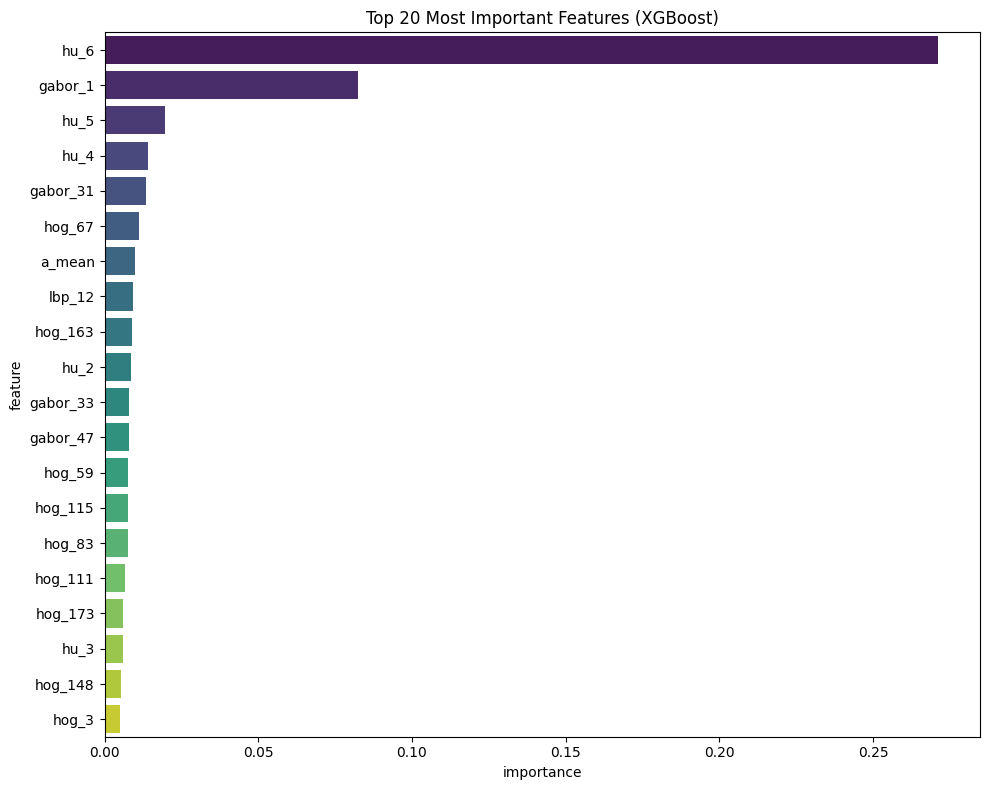

In [30]:
# --- NEW CELL: Feature Importance Analysis (Run after training) ---

# We need a list of your feature names for plotting
# Let's create them (this is a bit manual, but you only do it once)

feature_names = []
# 1. HSV (6)
feature_names.extend(['h_mean', 'h_std', 's_mean', 's_std', 'v_mean', 'v_std'])
# 2. GLCM (4)
feature_names.extend(['glcm_contrast', 'glcm_homogeneity', 'glcm_energy', 'glcm_correlation'])
# 3. HOG (192)
feature_names.extend([f'hog_{i}' for i in range(192)])
# 4. Edge Density (1)
feature_names.extend(['edge_density'])
# 5. Harris Corner (1)
feature_names.extend(['harris_corners'])
# 6. FAST Keypoints (1)
feature_names.extend(['fast_keypoints'])
# 7. L*a*b* (6)
feature_names.extend(['l_mean', 'l_std', 'a_mean', 'a_std', 'b_mean', 'b_std'])
# 8. Hu Moments (7)
feature_names.extend([f'hu_{i}' for i in range(7)])
# 9. LBP (26)
feature_names.extend([f'lbp_{i}' for i in range(26)])
# 10. Gabor (64)
feature_names.extend([f'gabor_{i}' for i in range(64)])

print(f"Total feature names created: {len(feature_names)}") # Should be 308

# --- Get importance from your trained XGBoost model ---
importances = xgb_model.feature_importances_

# Create a DataFrame for easy analysis
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\n--- Feature Importance (Top 20) ---")
print(feature_importance_df.head(20))

print("\n--- Features with ZERO Importance (Safe to remove) ---")
zero_importance_features = feature_importance_df[feature_importance_df['importance'] == 0]
print(f"Found {len(zero_importance_features)} features with 0 importance.")
print(zero_importance_features['feature'].tolist())

# --- Plot the Top 20 Features ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', 
            y='feature', 
            data=feature_importance_df.head(20),
            palette='viridis')
plt.title('Top 20 Most Important Features (XGBoost)')
plt.tight_layout()
plt.savefig('feature_importance_plot.png')
print("\nSaved 'feature_importance_plot.png' showing top features.")

In [31]:
# --- NEW CELL: Redundancy Analysis (Run *before* SMOTE) ---

# 1. Create a DataFrame from your *training features*
# We use X_train_features, NOT X_train_resampled
X_train_features_df = pd.DataFrame(X_train_features, columns=feature_names)

# 2. Calculate the correlation matrix
corr_matrix = X_train_features_df.corr().abs()

# 3. Find redundant pairs
# We create a mask to only show the upper triangle of the matrix (avoids duplicates)
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 4. Find features with correlation > 0.95 (a good starting threshold)
high_corr_threshold = 0.95
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > high_corr_threshold)]

print(f"Found {len(to_drop)} features to drop due to high correlation (> {high_corr_threshold}):")
print(to_drop)

# --- How to use this ---
# Now, you would drop these columns from your X_train_features and X_test_features
# For example:
# X_train_features_filtered = X_train_features_df.drop(columns=to_drop)
# X_test_features_filtered = pd.DataFrame(X_test_features, columns=feature_names).drop(columns=to_drop)
#
# ...then you would run SMOTE on X_train_features_filtered...
# ...and train your models on the filtered data...

Found 59 features to drop due to high correlation (> 0.95):
['l_mean', 'l_std', 'hu_3', 'lbp_8', 'lbp_9', 'lbp_10', 'lbp_11', 'lbp_12', 'lbp_13', 'gabor_0', 'gabor_2', 'gabor_4', 'gabor_6', 'gabor_7', 'gabor_8', 'gabor_9', 'gabor_11', 'gabor_12', 'gabor_13', 'gabor_16', 'gabor_18', 'gabor_19', 'gabor_20', 'gabor_22', 'gabor_24', 'gabor_25', 'gabor_26', 'gabor_27', 'gabor_28', 'gabor_30', 'gabor_32', 'gabor_33', 'gabor_34', 'gabor_36', 'gabor_37', 'gabor_38', 'gabor_39', 'gabor_40', 'gabor_41', 'gabor_42', 'gabor_43', 'gabor_44', 'gabor_45', 'gabor_46', 'gabor_47', 'gabor_48', 'gabor_49', 'gabor_50', 'gabor_51', 'gabor_52', 'gabor_54', 'gabor_56', 'gabor_57', 'gabor_58', 'gabor_59', 'gabor_60', 'gabor_61', 'gabor_62', 'gabor_63']
